In [1]:
import re
import os
import gc
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from IPython.display import Image
tqdm.pandas()
logging.basicConfig(level=logging.DEBUG)
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# Image(filename = "Model_Structure.png")

In [123]:
"""
Load data
"""
df = pd.read_excel('medical_sieve_training_set_lower.xlsx')
df_t = pd.read_excel('medical_sieve_test_set_lower.xlsx')
df.info()
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24603 entries, 0 to 24602
Data columns (total 9 columns):
aspect                    24603 non-null object
course_of_problem         24603 non-null object
group                     24603 non-null object
id                        24603 non-null object
text                      24603 non-null object
trainOrtest               24603 non-null object
treatment                 24603 non-null object
ground_truth_subaspect    24603 non-null object
ground_truth_sentiment    24603 non-null int64
dtypes: int64(1), object(8)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
aspect                    5000 non-null object
course_of_problem         5000 non-null object
group                     5000 non-null object
id                        5000 non-null object
test                      5000 non-null object
text                      5000 non-null object
trainOrtest           

In [124]:
import re
def process(x):
    ans = set()
    for each in x[1:-1].split(','): 
        words = each.strip().strip('"').strip("'")
        m = re.match('(\w+)-', words)
        if m is not None:
            ans.add(m[1])
#         else:
#             ans.add(words)
    return list(ans)
df['ground_truth_aspect'] = df['ground_truth_subaspect'].apply(lambda x: process(x))
df_t['ground_truth_aspect'] = df_t['ground_truth_subaspect'].apply(lambda x: process(x))
df['ground_truth_sentiment'] = df['ground_truth_sentiment'].apply(lambda x: 1 if x == 2 else x)
df_t['ground_truth_sentiment'] = df['ground_truth_sentiment'].apply(lambda x: 1 if x == 2 else x)
df_dev = df_t[:2500]
df_test = df_t[2500:]

In [125]:
# from random import random
# for index, each in enumerate(df.loc[:]['ground_truth_aspect']):
#     if each == ['not about'] and random() > 0.5 :
#         df = df.drop(index=index)
df['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],17239
1,[access],2797
2,[costs],1613
3,[trusts],1071
4,[errors],1000
5,[delays],857
6,"[costs, access]",11
7,"[costs, trusts]",4
8,"[delays, access]",3
9,"[access, costs]",3


In [71]:
df_t['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],3955
1,[access],356
2,[costs],250
3,[delays],181
4,[trusts],151
5,[errors],107


In [72]:
df_dev['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1962
1,[access],189
2,[costs],129
3,[delays],86
4,[trusts],81
5,[errors],53


In [73]:
df_test['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1993
1,[access],167
2,[costs],121
3,[delays],95
4,[trusts],70
5,[errors],54


In [126]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer


mlb_aspect = MultiLabelBinarizer()
mlb_aspect.fit(df['ground_truth_aspect'])
aspect_vectors_train = mlb_aspect.transform(df['ground_truth_aspect'])
aspect_vectors_dev = mlb_aspect.transform(df_dev['ground_truth_aspect'])
aspect_vectors_test = mlb_aspect.transform(df_test['ground_truth_aspect'])
print("Unique types of compliant:\n",mlb_aspect.classes_)

# lb_sentiment = LabelBinarizer()
# lb_sentiment.fit(list(df['ground_truth_sentiment']) + list(df_t['ground_truth_sentiment']))
# sentiment_vectors_train = lb_sentiment.transform(df['ground_truth_sentiment'])
# sentiment_vectors_dev = lb_sentiment.transform(df_dev['ground_truth_sentiment'])
# sentiment_vectors_test = lb_sentiment.transform(df_test['ground_truth_sentiment'])

from keras.utils import to_categorical
sentiment_vectors_train = list(df['ground_truth_sentiment'])
sentiment_vectors_dev = list(df_dev['ground_truth_sentiment'])
sentiment_vectors_test = list(df_test['ground_truth_sentiment'])

print("Unique sentiments: ",lb_sentiment.classes_)
lb_group = LabelBinarizer()
lb_group.fit(list(df['group']) + list(df_t['group']))
group_vectors_train = lb_group.transform(df['group'])
group_vectors_dev = lb_group.transform(df_dev['group'])
group_vectors_test = lb_group.transform(df_test['group'])

Unique types of compliant:
 ['access' 'costs' 'delays' 'errors' 'trusts']
Unique sentiments:  [0 1]


0    16851
1     7752
Name: ground_truth_sentiment, dtype: int64


Text(0, 0.5, 'count')

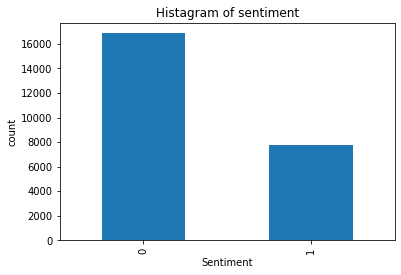

In [128]:
print(df['ground_truth_sentiment'].value_counts())
df['ground_truth_sentiment'].value_counts().plot.bar()
plt.title('Histagram of sentiment')
plt.xlabel('Sentiment')
plt.ylabel('count')

Text(0, 0.5, 'count')

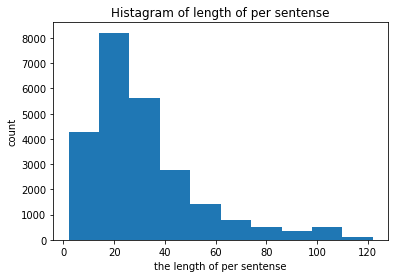

In [76]:
df['text'].apply(lambda x: len(x.split())).hist(grid=False)
plt.title('Histagram of length of per sentense')
plt.xlabel('the length of per sentense')
plt.ylabel('count')

In [129]:
MAX_SEQUENCE_LEN = 128
MAX_FEATURES = 481731
ASPECT_OUTPUT_DIM = len(mlb_aspect.classes_)
SENTIMENT_OUTPUT_DIM = 1
GROUP_DIM = len(lb_group.classes_)
print("aspect_out_put: {}, senntiment_out_put: {}, group_dim: {}".format(ASPECT_OUTPUT_DIM, SENTIMENT_OUTPUT_DIM, GROUP_DIM))

aspect_out_put: 5, senntiment_out_put: 1, group_dim: 277


In [12]:
"""
Fit tokenizer
"""
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
logging.info("Fitting Tokenizer")

tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)
# Updates internal vocabulary based on a list of texts
whole_text = []
with open('medical_sieve_sentence_corpus.txt', 'r') as f:
    for each in f.readlines():
        whole_text.append(each.strip())
f.close()
tokenizer.fit_on_texts(whole_text)

logging.info("Beginning process train text")
train_text = tokenizer.texts_to_sequences(df['text'])
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process dev text")
dev_text = tokenizer.texts_to_sequences(df_dev['text'])
dev_text = pad_sequences(dev_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process test text")
test_text = tokenizer.texts_to_sequences(df_test['text'])
test_text = pad_sequences(test_text, maxlen=MAX_SEQUENCE_LEN)

Using TensorFlow backend.
INFO:root:Fitting Tokenizer
INFO:root:Beginning process train text
INFO:root:Beginning process dev text
INFO:root:Beginning process test text


In [13]:
word_index = tokenizer.word_index
print('length:', len(word_index))
# del tokenizer
gc.collect()

length: 389618


20

In [44]:
"""
Get word Embedding
"""
# EMB_PATH = "cbow_model_medical_sieve_lower.vec"
# EMBEDDING_DIM = 300

# def get_coefs(word,*arr):
#     return word, np.asarray(arr, dtype='float32')

# def load_embeddings(embed_dir=EMB_PATH):
#     embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
#     return embedding_index

EMB_PATH  = "glove.840B.300d.txt"
EMBEDDING_DIM = 300

def load_embeddings(embedding_path=EMB_PATH):
    '''return a dict whose key is word, value is pretrained word embedding'''
    embeddings_index = {}
    f = open(embedding_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        try:
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            print("Err on ", values[:2])
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return embeddings_index

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [45]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embeddings_index)
del embeddings_index
gc.collect()

Err on  ['.', '.']
Err on  ['at', 'name@domain.com']
Err on  ['.', '.']
Err on  ['to', 'name@domain.com']
Err on  ['.', '.']
Err on  ['.', '.']
Err on  ['email', 'name@domain.com']
Err on  ['or', 'name@domain.com']
Err on  ['contact', 'name@domain.com']
Err on  ['Email', 'name@domain.com']
Err on  ['on', 'name@domain.com']
Err on  ['At', 'Killerseats.com']
Err on  ['by', 'name@domain.com']
Err on  ['in', 'mylot.com']
Err on  ['emailing', 'name@domain.com']
Err on  ['Contact', 'name@domain.com']
Err on  ['at', 'name@domain.com']
Err on  ['•', 'name@domain.com']
Err on  ['at', 'Amazon.com']
Err on  ['is', 'name@domain.com']
Total 2195884 word vectors.


200

In [46]:
"""
Attention model
"""


from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1],),
                                 initializer = self.init,
                                 name = '{}_W'.format(self.name),
                                 regularizer = self.W_regularizer,
                                 constraint = self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer = 'zero',
                                     name = '{}_b'.format(self.name),
                                     regularizer = self.b_regularizer,
                                     constraint = self.b_constraint)
        else:
            self.b = None
        
        self.built = True
    
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        e_ij = K.reshape(K.dot(
                            K.reshape(x, (-1, features_dim)),
                            K.reshape(self.W, (features_dim, 1))
                    ), (-1, step_dim))
        if self.bias:
            e_ij += self.b
        
        e_ij = K.tanh(e_ij)
        
        a = K.exp(e_ij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(),
                    K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [130]:
"""
Model builder
"""

from keras.layers import SpatialDropout1D, Bidirectional, Dense, LSTM
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.layers import concatenate
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adagrad, Adam
from bpmll import bp_mll_loss
from keras import backend as K
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

def build_model(verbose = False, compile = True):
    sequence_input = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LEN,
                                trainable=False)
    
    x = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.25)(x)        
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    attention = Attention(MAX_SEQUENCE_LEN)(x)
    conv = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool1 = GlobalAveragePooling1D()(conv)
    max_pool1 = GlobalMaxPooling1D()(conv)
    
    avg_pool2 = GlobalAveragePooling1D()(x)
    max_pool2 = GlobalMaxPooling1D()(x)

#     group_input = Input(shape=(GROUP_DIM,), dtype='float32')
    x = concatenate([attention, 
                     avg_pool1, max_pool1, 
                     avg_pool2, max_pool2])
    
    preds = Dense(SENTIMENT_OUTPUT_DIM, activation='sigmoid')(x)
    model = Model(sequence_input, preds)
    if verbose:
        model.summary()
    # the loss for sentiment analysis
#     if compile:
#         model.compile(loss='binary_crossentropy',
#                       optimizer=Adam(0.005),
#                       metrics=['acc'])
    # the loss for aspect classification
    if compile:
        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['acc'])
    return model

In [131]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 128, 300)     116885700   input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 128, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128, 128)     186880      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_2 (

In [132]:
"""
Training Session
"""
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

BATCH_SIZE = 256
NUM_EPOCHS = 100


class_weights = class_weight.compute_class_weight('balanced', lb_sentiment.classes_, df['ground_truth_sentiment'])

K.clear_session()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath="Pooled_RNN_ATTENTION_TEXT_CNN_weights_"+str(BATCH_SIZE)+"_sentiment_binary.hdf5", verbose=1, save_best_only=True)
model = build_model()
model.fit(x = train_text,
          y = sentiment_vectors_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          validation_data = (dev_text,
                             sentiment_vectors_dev),
          callbacks = [reduce_lr, es, checkpointer],
          class_weight=class_weights
         )
model.load_weights("Pooled_RNN_ATTENTION_TEXT_CNN_weights_"+str(BATCH_SIZE)+"_sentiment_binary.hdf5")
# test_preds /= 5

Train on 24603 samples, validate on 2500 samples
Epoch 1/100
24603/24603 [==============================] - 83s 3ms/step - loss: 0.5665 - acc: 0.7071 - val_loss: 0.7372 - val_acc: 0.5800

Epoch 00001: val_loss improved from inf to 0.73721, saving model to Pooled_RNN_ATTENTION_TEXT_CNN_weights_256_sentiment_binary.hdf5
Epoch 2/100
24603/24603 [==============================] - 78s 3ms/step - loss: 0.5108 - acc: 0.7421 - val_loss: 0.7484 - val_acc: 0.6088

Epoch 00002: val_loss did not improve from 0.73721
Epoch 3/100
24603/24603 [==============================] - 78s 3ms/step - loss: 0.4962 - acc: 0.7543 - val_loss: 0.7823 - val_acc: 0.6080

Epoch 00003: val_loss did not improve from 0.73721
Epoch 4/100
24603/24603 [==============================] - 82s 3ms/step - loss: 0.4864 - acc: 0.7601 - val_loss: 0.7646 - val_acc: 0.6352

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00004: val_loss did not improve from 0.73721
Epoch 5/100
24603/24603 [====

In [150]:
val_preds = lb_sentiment.inverse_transform(model.predict(dev_text))
sentiment_gt = lb_sentiment.inverse_transform(sentiment_vectors_dev)
# val_preds = [1 if x >= 0.5 else 0 for x in model.predict(dev_text) ]
# sentiment_gt = sentiment_vectors_dev

In [152]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(sentiment_gt, val_preds, labels=[0, 1, 2]))
print(classification_report(sentiment_gt, val_preds, target_names=['non negative', 'somewhat negative', 'very negative']))
# print(confusion_matrix(sentiment_gt, val_preds, labels=[0, 1]))
# print(classification_report(sentiment_gt, val_preds, target_names=['non negative', 'negative']))

[[1392  328    0]
 [ 618  162    0]
 [   0    0    0]]


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [58]:
val_preds = lb_sentiment.inverse_transform(model.predict(test_text))
sentiment_gt = lb_sentiment.inverse_transform(sentiment_vectors_test)

In [59]:
print(confusion_matrix(sentiment_gt, val_preds, labels=[0, 1, 2]))
print(classification_report(sentiment_gt, val_preds, target_names=['not about', 'somewhat negative', 'very negative']))

[[1409  274    2]
 [ 312  333    1]
 [  25  141    3]]
                   precision    recall  f1-score   support

        not about       0.81      0.84      0.82      1685
somewhat negative       0.45      0.52      0.48       646
    very negative       0.50      0.02      0.03       169

         accuracy                           0.70      2500
        macro avg       0.58      0.46      0.44      2500
     weighted avg       0.69      0.70      0.68      2500



In [67]:
select_predict_sentiment  = 1
select_ground_truth_sentiment = 0
index = 0
for gt, pre in zip(sentiment_gt, val_preds):
    if gt == select_ground_truth_sentiment and pre == select_predict_sentiment:
        print("index: {}, ground truth: {}, predict result: {}". format(index, gt, pre))
        print(df.loc[index]['text'])
    index += 1

index: 1, ground truth: 0, predict result: 1
you mentioned your daily exercise routine and that might be way too much and strenuous for now - slow down maggi , you move too fast .
index: 2, ground truth: 0, predict result: 1
misssy ! you do not have to say sorry to anyone in the world , especially this forum , for doing what addicts do .
index: 6, ground truth: 0, predict result: 1
i can not afford to lose any more weight , i have already lost too much .
index: 7, ground truth: 0, predict result: 1
my money is on pppd .
index: 22, ground truth: 0, predict result: 1
my last examination he said everything is looking normal down below and discharged me and made me thin i am wasting their time .
index: 28, ground truth: 0, predict result: 1
i would also pursue further consultations investigations by your consultant to get a better managed situation , since most achalasians seem to get to a point where the disorder is tolerable in most circumstances .
index: 37, ground truth: 0, predict res

In [41]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score

def f1(matrix):
    precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
    recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
    return 2*((precision*recall)/(precision+recall))

max_avg_f1 = 0
max_hamming_score = 0
max_exact_accuracy = 0
max_fuzzy_accuracy = 0
max_fuzzy_accuracy_pos = 0
max_exact_accuracy_pos = 0
max_avg_rocauc = 0
max_confusion_matrix = None
max_threshold_set = []

for threshold_set in thresholds_set:
    predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each >= threshold_set[index]:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
    num_fuzzy_match = 0
    num_fuzzy_match_pos = 0
    num_exact_match_pos = 0
    num_pos = 0
    for  true, pre in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
        if len(true) != 0: 
            num_pos += 1
        intersect = set(pre).intersection(set(true))
        if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
            num_fuzzy_match += 1
        if len(true)>0 and len(pre)>0 and len(intersect) > 0:
            num_fuzzy_match_pos += 1
        if len(true)>0 and len(pre)>0 and pre == true: 
            num_exact_match_pos += 1
    fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
    exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
    fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
    exact_accuracy_pos = num_exact_match_pos*1.0/num_pos

    rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
    
    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
        

    if np.mean(class_f1) > max_avg_f1:
        max_threshold_set = threshold_set
        max_avg_f1 = max(max_avg_f1, np.mean(class_f1))
        max_hamming_score = hamming_score
        max_exact_accuracy = exact_accuracy
        max_fuzzy_accuracy = fuzzy_accuracy 
        max_exact_accuracy_pos = exact_accuracy_pos
        max_fuzzy_accuracy_pos = fuzzy_accuracy_pos
        max_avg_rocauc = rocauc_score
        max_confusion_matrix = multilabel_confusion_matrix(aspect_vectors, predict_softmax)
        
        

print("threshold set:", max_threshold_set)
print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(max_confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", max_hamming_score)
print("Exact accuracy:", max_exact_accuracy)
print("Fuzzy accuracy:", max_fuzzy_accuracy)
print("Exact accuracy (exclude negative):", max_exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", max_fuzzy_accuracy_pos)
print("Average F1 Score: ", max_avg_f1)
print("Average ROC AUC Score: ", max_avg_rocauc)

threshold set: [0.55, 0.2, 0.25, 0.4, 0.25]
Confusion Matrix for Each Aspect:
[[[2169  164]
  [  32  135]]

 [[2287   92]
  [  21  100]]

 [[2324   81]
  [  36   59]]

 [[2403   43]
  [  23   31]]

 [[2369   61]
  [  37   33]]]
Result of Metrics for Evaluation:
Hamming score: 0.9528
Exact accuracy: 0.7724
Fuzzy accuracy: 0.7748
Exact accuracy (exclude negative): 0.6942800788954635
Fuzzy accuracy (exclude negative): 0.7061143984220908
Average F1 Score:  0.5214636922756722
Average ROC AUC Score:  0.9498462538522947


In [26]:
# """
# Training Session
# """
# from sklearn.model_selection import KFold
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.callbacks import ReduceLROnPlateau
# from sklearn.utils import class_weight

# BATCH_SIZE = 1024
# NUM_EPOCHS = 100
# FOLDER_NUM = 5

# class_weights = class_weight.compute_class_weight('balanced', lb_sentiment.classes_, df['ground_truth_sentiment'])

# # splits = list(KFold(n_splits=FOLDER_NUM).split(train_text, aspect_vectors))
# splits = list(KFold(n_splits=FOLDER_NUM, random_state=0).split(train_text, aspect_vectors_train))

# # test_preds = np.zeros((test_text.shape[0]))
# folders = [i for i in range(FOLDER_NUM)]

# for folder in folders:
#     K.clear_session()
#     train_index, validate_index = splits[folder]
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
#     checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
#     model = build_model()
#     model.fit(x = [train_text[train_index], group_vectors_train[train_index]],
#               y = aspect_vectors_train[train_index],
#               batch_size = BATCH_SIZE,
#               epochs = NUM_EPOCHS,
#               validation_data = ([train_text[validate_index],group_vectors_train[validate_index]],
#                                  aspect_vectors_train[validate_index]),
#               callbacks = [reduce_lr, es, checkpointer]
# #               class_weight=class_weights
#              )
#     val_preds = model.predict([train_text[validate_index],group_vectors_train[validate_index]])
#     break
# # test_preds /= 5

In [27]:
# from sklearn.metrics import hamming_loss
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import multilabel_confusion_matrix
# for threshold in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     print('*'*20)
#     print("Threshold:", threshold)
#     print('*'*20)
#     predict_softmax = np.zeros(aspect_vectors_train[validate_index].shape, dtype=int)
#     for row_index, row in enumerate(val_preds):
#         for index, each in enumerate(row):
#             if each > 0.09:
#                 predict_softmax[row_index][index] = 1

#     hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors_train[validate_index]) 
#     acc = accuracy_score(predict_softmax, aspect_vectors_train[validate_index])
#     fuzzy_acc = 0
#     for pre, true, in zip(mlb_aspect.inverse_transform(predict_softmax), mlb_aspect.inverse_transform(aspect_vectors_train[validate_index])):
#         intersect = set(pre).intersection(set(true))
#         if intersect != None and len(intersect) > 0:
#             fuzzy_acc += 1
#     fuzzy_acc = fuzzy_acc*1.0 / len(predict_softmax)
#     print("hamming score:", hamming_score)
#     print("exact accuracy:", acc)
#     print("fuzzy accuracy:", fuzzy_acc)


#     def f1(matrix):
#         precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
#         recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
#         return 2*((precision*recall)/(precision+recall))
#     class_f1 = []
#     for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors_train[validate_index], predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
#         class_f1.append(f1(confusion_matrix))
#     print("average f1 score: ", np.mean(class_f1))